<a href="https://colab.research.google.com/github/DPK-VT/MLTESTS/blob/main/Currency_ECBTest4withforecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Index(['Date', 'EUR/USD', 'EUR/JPY', 'EUR/GBP', 'EUR/CHF', 'EUR/AUD'], dtype='object')
Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0553 - val_loss: 2.3283e-04
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 5.8699e-04 - val_loss: 2.0892e-04
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 5.1117e-04 - val_loss: 2.2065e-04
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 5.0265e-04 - val_loss: 1.8002e-04
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 4.2670e-04 - val_loss: 2.0235e-04
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 4.7987e-04 - val_loss: 1.9492e-04
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 4.1330e-04 - val_loss: 1.5622e-04
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 3.6434e-04 - val_loss: 2.5631e-04
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 4.0337e-04 - val_loss: 1.4181e-04
Epoch 10/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - los

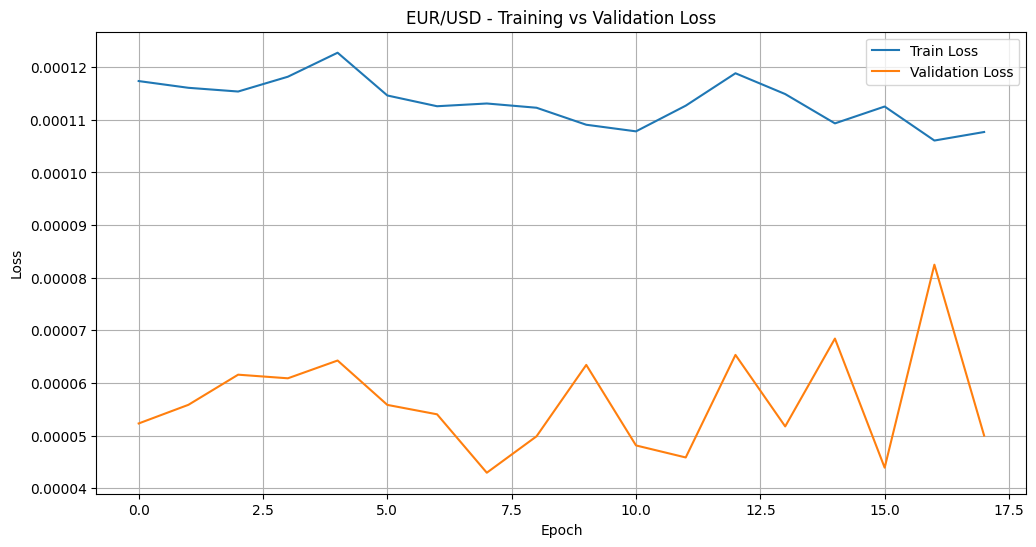

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Evaluation for EUR/USD
RMSE: 0.0051
MAE: 0.0040


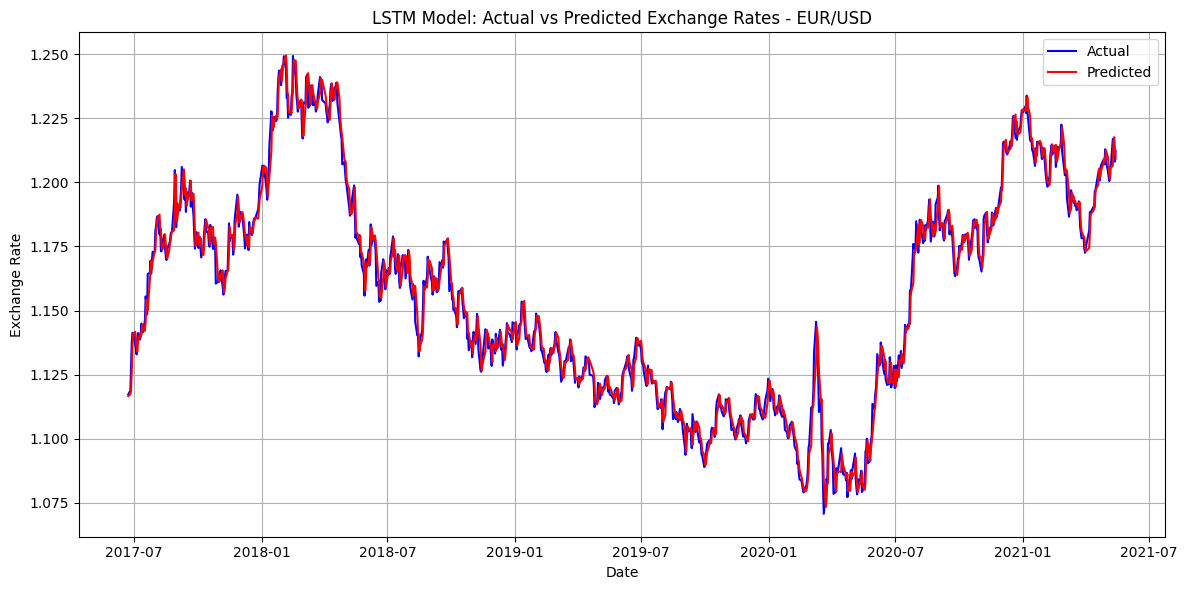

EUR/USD - RMSE: 0.0051
EUR/USD - MAE : 0.0040


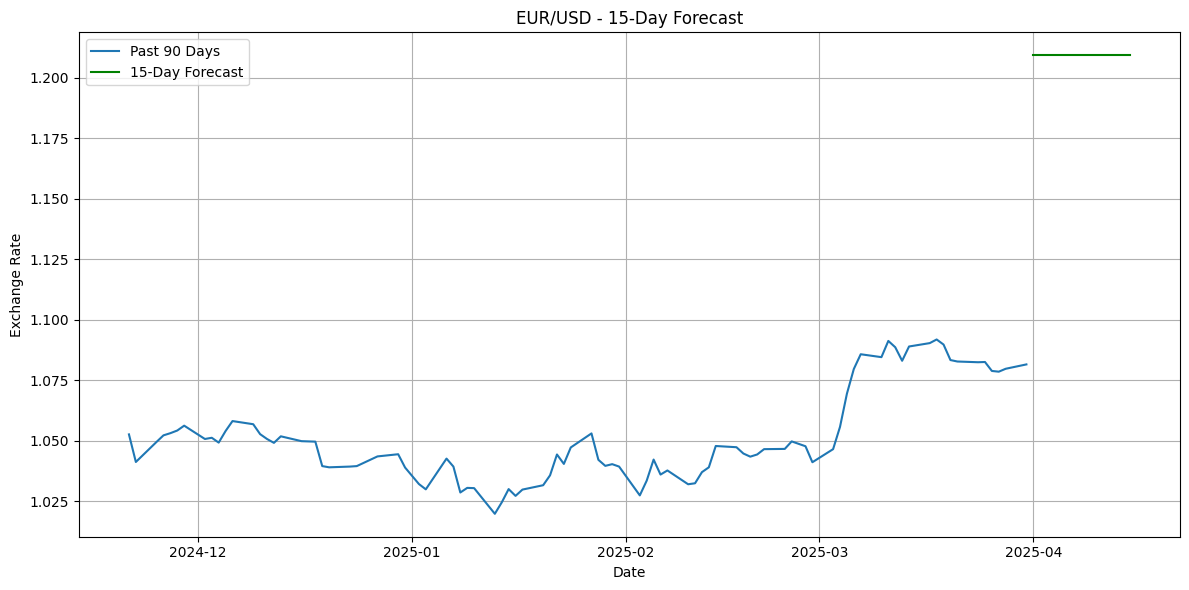

In [4]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Read Excel file
df = pd.read_excel('ECB_exchange_rates_march31.xlsx', engine='openpyxl')  # Replace with the exact filename
print(df.columns)
# Renaming the column for EUR/USD exchange rate
#df = df.rename(columns={'USD': 'EUR/USD'})  # Adjust according to your dataset

# Set the 'Date' column as index and sort it
#df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')  # Make sure the date format matches your data
#df.set_index('Date', inplace=True)
#df.sort_index(inplace=True)

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

#select currency
currency = 'EUR/USD'  # Change this to one of: 'EUR/USD', 'EUR/JPY', 'EUR/GBP', 'EUR/CHF', 'EUR/AUD'
data = df[[currency]].copy()
data = data.dropna()

# Scaling the data MinMax
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[[currency]])

# Create the dataset with a 90-day window size

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 90
X, y = create_sequences(scaled_data, window_size)

#old code for sequence
#window_size = 90
#X, y = [], []

#for i in range(window_size, len(scaled_data)):
    #X.append(scaled_data[i-window_size:i, 0])  # Last 90 days as features
    #y.append(scaled_data[i, 0])  # The value to predict (next day's exchange rate)

#X, y = np.array(X), np.array(y)

# Splitting data into training and validation sets
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Reshaping X for LSTM: [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_val = X_val.reshape(X_val.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)


# Build the LSTM model
#model = Sequential()
#model.add(Input(shape=(window_size, 1)))  # <== Use Input layer first
#model.add(LSTM(50, return_sequences=False))
#model.add(Dense(1))
#model.compile(optimizer='adam', loss='mean_squared_error')
model = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(50, return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Training the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=2, callbacks=[early_stopping])

# Save the model and scaler
model.save(f"{currency.replace('/', '_')}_lstm_model.keras")
joblib.dump(scaler, f"{currency.replace('/', '_')}_scaler.pkl")

# Plotting the loss curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{currency} - Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Predictions
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y_val.reshape(-1, 1))

# Metrics
rmse = np.sqrt(mean_squared_error(actual, predictions))
mae = mean_absolute_error(actual, predictions)

print(f"\nEvaluation for {currency}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


# Get the correct index for validation
val_index = data.index[train_size + window_size: train_size + window_size + len(y_val)]

# Calculate y_val_inv before using it in the plot
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))

# Plotting actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(val_index, y_val_inv, label='Actual', color='blue')
plt.plot(val_index, predictions, label='Predicted', color='red')
plt.title(f'LSTM Model: Actual vs Predicted Exchange Rates - {currency}')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Calculate evaluation metrics on validation data
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))
predicted_actual = predictions  # already inverse-transformed earlier

rmse = np.sqrt(mean_squared_error(y_val_inv, predicted_actual))
mae = mean_absolute_error(y_val_inv, predicted_actual)

print(f"{currency} - RMSE: {rmse:.4f}")
print(f"{currency} - MAE : {mae:.4f}")


# Forecast future 15 days
forecast_input = X_val[-1]  # Shape: (window_size, 1)
forecast = []

for _ in range(15):
    next_pred = model.predict(forecast_input.reshape(1, window_size, 1), verbose=0)
    forecast.append(next_pred[0, 0])

# Update the input sequence by appending the new prediction and removing the oldest
next_step = np.array([[next_pred[0, 0]]])  # Shape: (1, 1)
forecast_input = np.vstack([forecast_input[1:], next_step])  # Shape stays (window_size, 1)

# Inverse transform the forecast to get real values
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Create forecast dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=15)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data.index[-90:], data[currency].values[-90:], label='Past 90 Days')
plt.plot(future_dates, forecast, label='15-Day Forecast', color='green')
plt.title(f"{currency} - 15-Day Forecast")
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()